In [1]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator_personalized, RyR, z_score_filter, reset_df
from utilities_plotting import plot_scatter, plot_capability
import _db_tools as db

def z_score_filter(df: pd.DataFrame, threshold: int) -> pd.DataFrame:
    """Applies a z-score filter to a DataFrame, removing values that do not meet the specified threshold.
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the measurements and limits.
    - threshold (float): The z-score threshold. Values exceeding this threshold will be replaced with NaN.
    Returns:
    pd.DataFrame: A new DataFrame with values that pass the z-score filter, while retaining the original limits columns.
    For each row in the input DataFrame, the function calculates the z-scores for the measurement values and
    replaces values with z-scores greater than the specified threshold with NaN. The original limits columns are retained.
    """
    rows = []
    measures = df.iloc[:, :-2]  #Indexes the measurements
    limits = df.iloc[:, -2:]  #Indexes the limits
    for row_idx in range(measures.shape[0]):  # Iterates over the rows
        row = measures.iloc[row_idx, :]
        if row.std() == 0: #If the standard deviation is zero, don't calculate z-scores and keep the original values
            filtered_row = row
        else:
            z_scores = (row - row.mean()) / row.std()  #Calculates the z-score
            filtered_row = np.where(abs(z_scores) <= threshold, row, np.nan)  #Applies the threshold as a filter
        rows.append(filtered_row)
    filtered_df = pd.DataFrame(rows)  #Builds a new DataFrame
    filtered_df = pd.concat([filtered_df, limits], axis=1)  #Adds back the columns
    return filtered_df

Database *input.db* found in: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_RyR_Analyser\database\input.db
Database *output.db* found in: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_RyR_Analyser\database\output.db


In [3]:
#Data extraction
table_names = ['TOP_PASSAT_B9_measurements_2023y_12m_13d_14h_49m_51s', 'TOP_PASSAT_B9_limits_2023y_12m_13d_14h_49m_51s']
MEAS = retrieve_data("input.db", table_names[0])
LIMITS = retrieve_data("input.db", table_names[1])

Table *TOP_PASSAT_B9_measurements_2023y_12m_13d_14h_49m_51s* retrieved succesfully.
Table *TOP_PASSAT_B9_limits_2023y_12m_13d_14h_49m_51s* retrieved succesfully.


RyR calculation

In [4]:
#Generate a RyR for each fiber in every scale
RyR_df = RyR(pd.concat([MEAS, LIMITS], axis=1))
RyR_df_format = rename_index(RyR_df)
print("RyR")
RyR_df_format

RyR


,RyR,Status
Guia_Luz_Blanco_FB1_X,15.491617,Low fail
Guia_Luz_Blanco_FB1_Y,14.632554,Low fail
Guia_Luz_Blanco_FB2_X,24.763172,Low fail
Guia_Luz_Blanco_FB2_Y,13.192028,Low fail
Guia_Luz_Blanco_FB3_X,14.374978,Low fail
Guia_Luz_Blanco_FB3_Y,26.363133,High fail
Guia_Luz_Blanco_FB4_X,13.450681,Low fail
Guia_Luz_Blanco_FB4_Y,10.295877,Low fail
Guia_Luz_Blanco_FB5_X,28.283117,High fail
Guia_Luz_Blanco_FB5_Y,14.691641,Low fail


Distribution Fitting

Z-score filtering of outliers

![title](../media/Z-score.jpg)

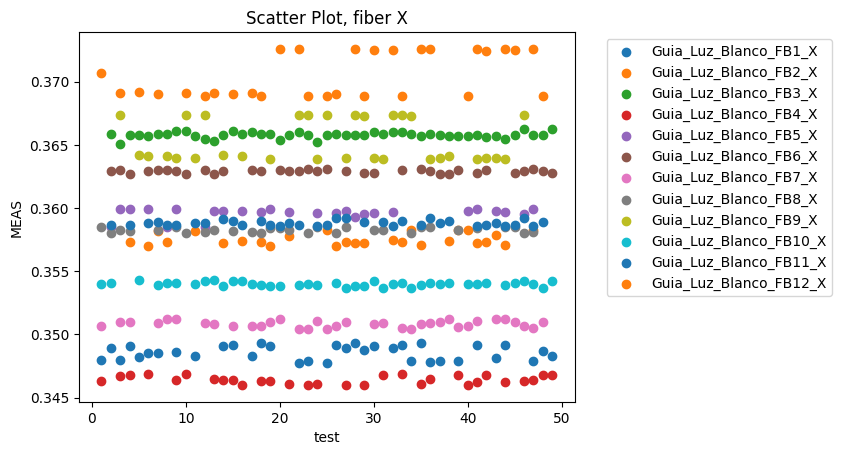

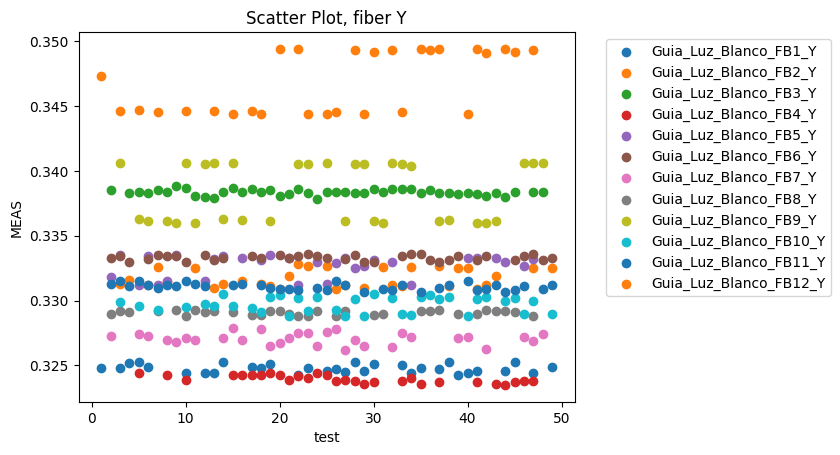

In [6]:
#Filter values by their row z-score
z_df = z_score_filter(pd.concat([MEAS, LIMITS], axis=1), 1)
#Plot the filtered values
plot_scatter(z_df.iloc[:, :-2], 'Scatter Plot, fiber X', 'test', 'MEAS', filter='x')
plot_scatter(z_df.iloc[:, :-2], 'Scatter Plot, fiber Y', 'test', 'MEAS', filter='y')

In [7]:
RyR_df = RyR(z_df)
RyR_df_filtered = rename_index(RyR_df)
print("RyR filtered")
RyR_df_filtered

RyR filtered


,RyR,Status
Guia_Luz_Blanco_FB1_X,7.918578,Correct
Guia_Luz_Blanco_FB1_Y,10.013603,Low fail
Guia_Luz_Blanco_FB2_X,16.926025,Low fail
Guia_Luz_Blanco_FB2_Y,8.625819,Correct
Guia_Luz_Blanco_FB3_X,5.075718,Correct
Guia_Luz_Blanco_FB3_Y,4.215456,Correct
Guia_Luz_Blanco_FB4_X,7.103791,Correct
Guia_Luz_Blanco_FB4_Y,5.737394,Correct
Guia_Luz_Blanco_FB5_X,20.358823,Low fail
Guia_Luz_Blanco_FB5_Y,7.701060,Correct


In [ ]:
##UNUSED
##Add both RyR to the database
""" confirmation = input("Do you want to export the new RyR to your database? (y/n): ").strip().lower()
if confirmation == 'y':
    RYR = pd.concat([RyRx, RyRy], axis=0).reset_index(drop=True)
    RYR_filtered = pd.concat([RyRx_filtered, RyRy_filtered], axis=0).reset_index(drop=True)
    prepare_database(RYR, glob.tooling+"_RyR") #Store a df inside the database of the project
    prepare_database(RYR_filtered, glob.tooling+"_RyR_filtered") #Store a df inside the database of the project
else:
    print("Operation canceled.") """